_Version log: Investigating the Hartley Transform_

In [36]:
import numpy as np
import matplotlib.pyplot as plt

c = 299_800_000

In [37]:
def gaussian(x, center, FWHM):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    normalisation_coeffient = 1  #1 /(sigma *(2*np.pi)**0.5)
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    return normalisation_coeffient *np.exp(exponent)

In [38]:
array_length = 400 #in pixels
pixel_pitch = 50 #in um
central_freq = 3 #in THz
FWHM_freq = 3 #in THz
theta = 60 #in arcminutes
noise_level = 20 #% of maximum amplitude
number_of_averages = 20 #Frames can be averaged to reduce noise during pre or post-processing. Will allow us to measure the variance.

In [39]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /c #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /c # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


57.2604893728845


In [40]:
wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = c *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
phase = [(-1)**n for n in range(len(wavenumbers))] #ensure that the center of each wave is positive.
amplitudes = phase *gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)

oversampled_wn = np.fft.rfftfreq(array_length *10, (pixel_pitch*1e-6))
oversampled_freqs = c *oversampled_wn /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
oversampled_phase = [(-1)**n for n in range(len(oversampled_wn))] #ensure that the center of each wave is positive.
oversampled_amps = oversampled_phase *gaussian(oversampled_wn, central_wavenumber, FWHM_wavenumber)



In [41]:
intensity = np.fft.irfft(amplitudes, norm= "forward")
intensity = np.tile(intensity, (number_of_averages,1))
noise = (2*np.random.rand(number_of_averages, array_length) -1) *np.max(np.abs(intensity)) *noise_level/100
intensity2 = intensity +noise
uncertainty = np.std(intensity2, axis= 0)
intensity3 = np.mean(intensity2, axis= 0)

displacement = [n *pixel_pitch*1e-3 for n in range(array_length)]

uncertainty.shape

(400,)

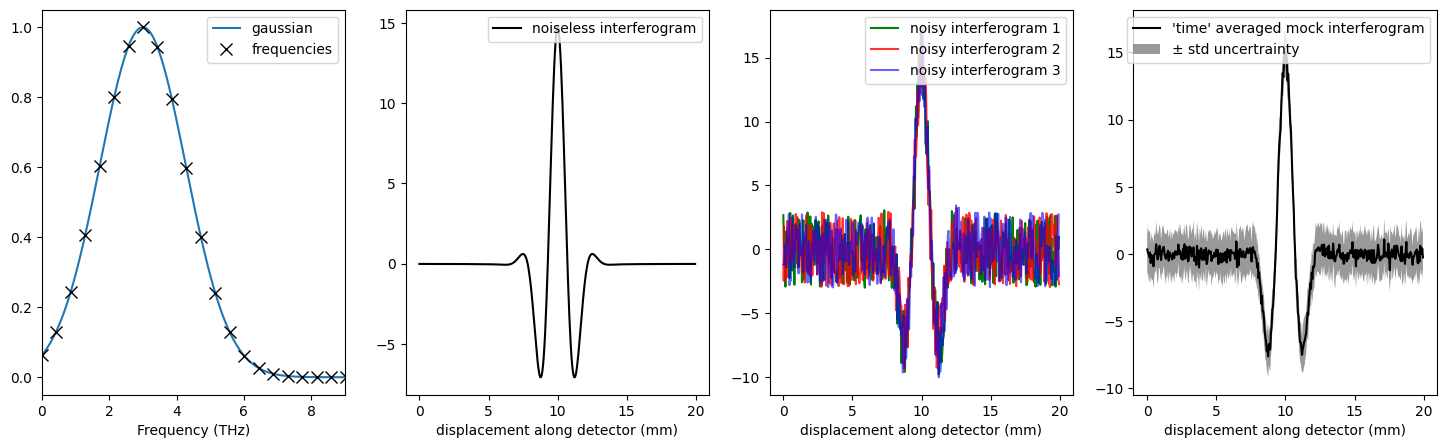

In [62]:
fig, axs = plt.subplots(1,4, figsize=(18,5))

axs[0].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs[0].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "frequencies")
axs[0].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs[0].legend(loc ="upper right")

axs[1].plot(displacement, intensity[0], color= "k", label= "noiseless interferogram")
axs[1].set(xlabel= "displacement along detector (mm)")
axs[1].legend(loc ="upper right")

axs[2].plot(displacement, intensity2[0], color= "green", alpha= 1, label= "noisy interferogram 1")
axs[2].plot(displacement, intensity2[1], color= "red", alpha= 0.8, label= "noisy interferogram 2")
axs[2].plot(displacement, intensity2[2], color= "blue", alpha= 0.6, label= "noisy interferogram 3")
axs[2].set(xlabel= "displacement along detector (mm)")
axs[2].legend(loc ="upper right")

axs[3].plot(displacement, intensity3, color= "k", label= "'time' averaged mock interferogram")
axs[3].set(xlabel= "displacement along detector (mm)")
axs[3].fill_between(displacement, intensity3-uncertainty, intensity3+uncertainty, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[3].legend(loc ="upper right")

plt.show()

In [ ]:
to_save = np.array([intensity, uncertainty]).T

#np.savetxt("data\\1dmockanderrors2.csv", to_save, delimiter=",")